# Vision Transformers

In this practical session we will build a **Vision Transformer (ViT)** for image classification using **pytorch**.

This approach was popularized by Dosovitskiy et al., "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" ([link to paper](https://openreview.net/forum?id=YicbFdNTTy)), who were the first to successfully train a tranformer on ImageNet.

We will build a smaller model to perform image classification on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).

This section is based on Eugenio Lomurno's TensorFlow ViT notebook from the [ANNDL class](https://boracchi.faculty.polimi.it/teaching/AN2DL.htm) and on a [tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html) by Phillip Lippe.

Let's start with some standard imports:

In [ ]:
import os
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

Let's set all random seeds for reproducibility:

In [ ]:
import random
seed = 42

def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

seed_everything(seed)

Some visualization settings:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

## Data Preprocessing

In [ ]:
# Normalize training images and apply some basic data augmentation
train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

# Test (and validation) images are just normalized
test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

# Download training data applying the preprocessing defined above
# Data are split into training and validation sets
# A seeding trick is used to make sure data augmentation is not applied to
# validation data
trainset = datasets.CIFAR10(root='./data', train=True, download=True,
                            transform=train_transform)

valset = datasets.CIFAR10(root='./data', train=True, download=True,
                              transform=test_transform)
seed_everything(42)
trainset, _ = torch.utils.data.random_split(trainset, [45000, 5000])
seed_everything(42)
_, valset = torch.utils.data.random_split(valset, [45000, 5000])

# We will access training and validation data through data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=128,
                                        shuffle=False)

# Download test data
testset = datasets.CIFAR10(root='./data', train=False, download=True,
                           transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# These are the names of the classes
# Later, we will use these for more than visualization...
class_names = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's see some images from the dataset to get an idea of the task.

The images are 32x32 RGB and there are 10 classes.

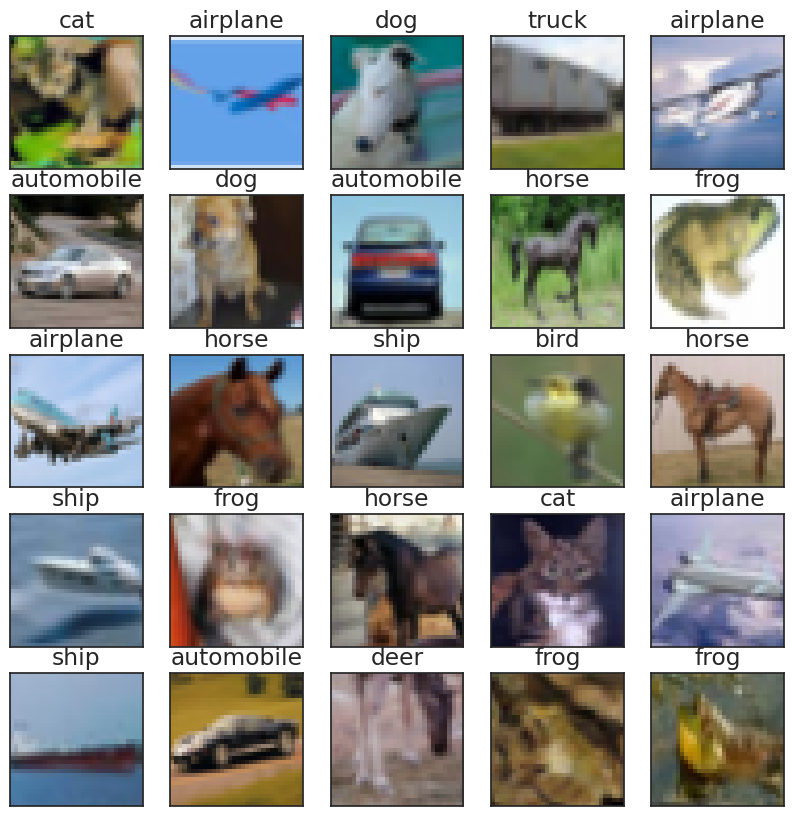

In [ ]:
# Function to display the image with pyplot (denormalize and transpose)
def to_plt(img):
  return np.transpose(img, (1, 2, 0)) * 0.5 + 0.5


# Function to visualise a subset of the dataset
def visualize_dataset(dataset, class_names):
    # Set up a 5x5 grid for images
    plt.figure(figsize=(10, 10))
    for i in range(25):
        # Select a random image index
        idx = np.random.randint(0, len(dataset))
        # Add subplot for the current image
        plt.subplot(5, 5, i + 1)
        # Remove axis markers
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        # Display the image
        x = dataset[idx][0]
        plt.imshow(to_plt(x))
        # Set the title using the class name
        plt.title(class_names[dataset[idx][1]])
    # Show the visualisation
    plt.show()

# Visualise a selection of training images
visualize_dataset(trainset, class_names)

Differently from Convolutional Neural Networks, we will not apply receptive fields to the images. Instead, we will process each image a a **sequence** of...patches.

Each 32x32 image will be represented as a sequence of 64 4x4 patches:

In [ ]:
# Input image dimensions
input_shape = (32, 32, 3)

# Size of each patch (4x4)
patch_size = 4

# Total number of patches
num_patches = (input_shape[0] // patch_size) ** 2

# Function to turn an image into a sequence of patches
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

Let's try this on an image from our training set

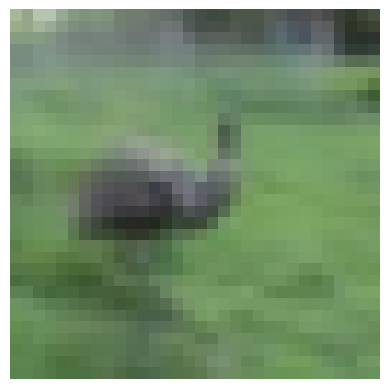

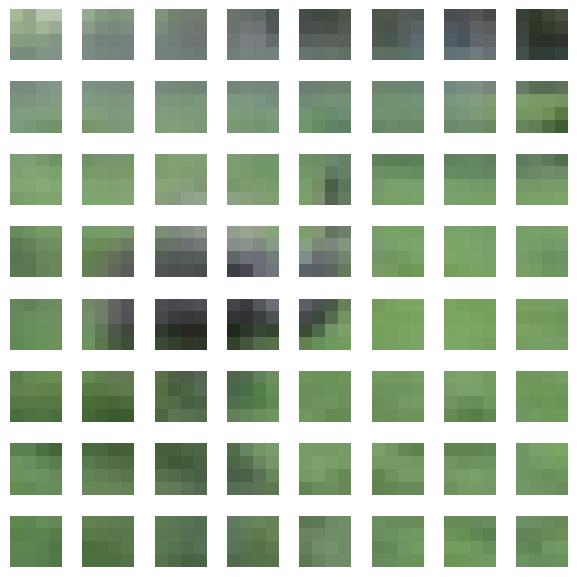

In [ ]:
# Pick an image
sample_img = trainset[1][0]
plt.axis('off')
plt.imshow(to_plt(sample_img))

# Decompose it into patches
img_patches = img_to_patch(sample_img[None], patch_size=4,
                           flatten_channels=False)[0]

def visualize_patches(patches, grid=False):
    # Extract patches from the input image
    n_patches = patches.shape[0]

    # Determine the grid size for visualising patches
    side = int(np.sqrt(n_patches))
    plt.figure(figsize=(6, 6))

    # Plot each patch
    for i in range(n_patches):
      if grid:
        plt.subplot(side, side, i + 1)
      else:
        plt.subplot(n_patches, 1, i + 1)
      patch = to_plt(patches[i])
      plt.imshow(patch)
      plt.axis('off')
    if grid:
      plt.tight_layout()
    plt.show()

# Visualise the patches
visualize_patches(img_patches, grid=True)
visualize_patches(img_patches, grid=False)

This was for visualization, but the 3x4x4 patches will be actually processed as **flat** vectors of size 48:

In [ ]:
flat_img_patches = img_to_patch(sample_img[None], patch_size=4,
                           flatten_channels=True)[0]

print("Shape of original image: ", sample_img.shape)
print("Shape of sequence of patches: ", img_patches.shape)
print("Shape of sequence of FLATTENED patches: ", flat_img_patches.shape)

Shape of original image:  torch.Size([3, 32, 32])
Shape of sequence of patches:  torch.Size([64, 3, 4, 4])
Shape of sequence of FLATTENED patches:  torch.Size([64, 48])


## Model Definition

Our model will be a stack of Pre-Layer Normalization (Pre-LN) Multi-Head Attention blocks:

![image.png](https://uvadlc-notebooks.readthedocs.io/en/latest/_images/pre_layer_norm.svg)

Let's start by defining our self-attention block with Pre-LN.

**TODO:** complete the definition of the attention block by implementing the `forward` method.
The following layers are already defined in the `__init__` using `torch.nn`:


*   Two [Layer Norm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) operations
*   A [Multi-Head Attention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) layer to be used for **self-attention**
*   A simple feed-forward network

Refer to the image above (b) and to pytorch documentation. Don't forget about the residual connections!

In [ ]:
# Pre-LN Attention block
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        # Layer Norm
        self.layer_norm_1 = nn.LayerNorm(embed_dim)

        # Multi-Head Attention
        # takes query, key, value
        # returns outputs and attention weights
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)

        # Layer Norm
        self.layer_norm_2 = nn.LayerNorm(embed_dim)

        # FFN (Feed Forward Network)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        # ...
        # SOLUTION
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        # END SOLUTION

        return x

Now we can build our ViT model by stacking:


*   A **linear** embedding of **flat** patches of dimension 3x4x4 = 48 into dimension `embed_dim` (256)
*   To this input embedding we concatenate a **learnable positional embedding** and a **class token**
*   A sequence of `num_layers` (6) of the attention blocks defined above
*   An MLP classification head *applied to the class token*





In [ ]:
class VisionTransformer(nn.Module):

    def __init__(self, embed_dim=256, hidden_dim=512, num_channels=3,
                 num_heads=8, num_layers=6, num_classes=10, patch_size=4,
                 num_patches=64, dropout=0.2):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim,
                        num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))


    def forward(self, x):
        # Preprocess input image into patches
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

## Training

Try to use GPU:

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cpu


We use cross entropy loss, Adam optimizer, and use our validation set to perform early stopping

In [ ]:
# **Initialize Model, Loss, Optimizer**
model = VisionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# **Early Stopping Parameters**
patience = 5  # Stop training if no improvement in 'patience' epochs
best_val_loss = float("inf")
early_stop_counter = 0

# **Prepare the training**
epochs = 10
model.train()

VisionTransformer(
  (input_layer): Linear(in_features=48, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=512, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Layer

Training loop (you may want to skip this on colab)

In [ ]:
# (DON'T) TRY THIS AT HOME
%%script false --no-raise-error

for epoch in range(epochs):
    total_loss = 0
    model.train()

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        # Convert labels to match known class indices
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(trainloader)

    # **Validation Phase**
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(valloader)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # **Early Stopping Check**
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0  # Reset counter since we improved
        # Save the best model
        os.makedirs("output_vit_cifar10", exist_ok=True)
        model_path = "output_vit_cifar10/best_model.pth"
        torch.save(model.state_dict(), model_path)
        print(f"New best model saved with Val Loss: {avg_val_loss:.4f}")
    else:
        early_stop_counter += 1
        print(f"No improvement for {early_stop_counter}/{patience} epochs.")

    # Stop training if no improvement for `patience` epochs
    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

print(f"Training completed. Best model saved at: {model_path}")

## Testing

Let's measure the accuracy of our model.

Load trained weights:

In [ ]:
model = VisionTransformer().to(device)
model.load_state_dict(torch.load("./best_model.pth", map_location=device))  # Load your own trained weights
model.eval()

VisionTransformer(
  (input_layer): Linear(in_features=48, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=512, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Layer

Compute accuracy of trained ViT on our test set:

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Test accuracy: {accuracy:.2f}%')

Test accuracy: 70.70%


Let's see some examples of classification:

True label: truck
Predicted: truck
truck: 62.49%
automobile: 37.44%
airplane: 0.04%
horse: 0.02%
ship: 0.01%
bird: 0.01%
dog: 0.00%
frog: 0.00%
cat: 0.00%
deer: 0.00%


<ipython-input-16-342757aa5e81>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(output[i])


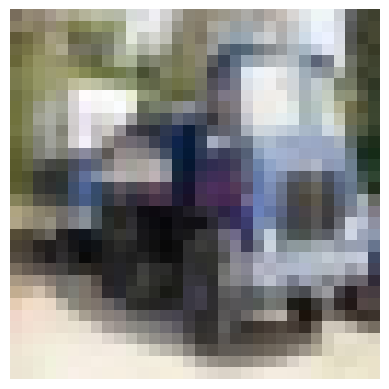

In [ ]:
testiter = iter(testloader)
images, labels = next(testiter)
input = images.to(device)
output = model(input)
_, predicted = torch.max(output, 1)

i = random.randint(0, len(images))
plt.axis('off')
plt.imshow(to_plt(images[i]))
print("True label: {}".format(class_names[labels[i]]))
print("Predicted: {}".format(class_names[predicted[i]]))
probs = torch.nn.functional.softmax(output[i])
for cn, p in sorted(zip(class_names, probs), key=lambda x: -x[1]):
  print("{}: {:.2f}%".format(cn, p*100))

# Zero Shot Classification with CLIP

**CLIP** (Contrastive Language-Image Pre-Training) is a multi-modal model published by OpenAI in 2021. It is trained on **image-text pairs**.

CLIP is composed of **two encoders** that embed images and captions (respectively) into the same vector space.

<img src="https://cdn.sanity.io/images/vr8gru94/production/46b85e640919609e98a79a8142a1181e57d12799-2803x1335.png" width="700">

The image encoder is a ViT (or a ResNet), the text encoder is a Transformer.

Data are images with captions (not necessarily connected to "class labels"), easily found online.

The two encoders are trained together using **contrastive learning**:

<img src="https://cdn.sanity.io/images/vr8gru94/production/b7e270212d57ff9dd2da60f8fac00c6dddef9c3a-1165x671.png" width="700">

*   Matching image-caption pairs must produce *similar* vectors
*   Misplaced image-caption pairs (generated by swapping) must produce *dissimilar* vectors


Similarity between vectors can be simply measured with **cosine similarity**:

$$k(v, w) = \frac{v^\top w}{\|v\|_2\|w\|_2}$$

that is just the cosine of the angle between the two vectors.

This section is inspired by Eugenio Lomurno's CLIP notebook from the [ANNDL class](https://boracchi.faculty.polimi.it/teaching/AN2DL.htm).

We will download a pre-trained CLIP model by [Hugging Face](https://github.com/huggingface) and use it to perform **zero-shot image classification** on CIFAR-10.

Zero-shot means that we are using a model **pre-trained** on a task that is *not* classification to perform classification with **no extra training time**.

We will just encode images and labels, then **measure to which label embedding the immage embedding is more similar**.

<img src="https://cdn.sanity.io/images/vr8gru94/production/d9a6ebbc9a2f3334ec57a6b54d90155043c07595-1292x447.png" width="700">

New and old imports (just in case):

In [ ]:
import os
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from transformers import CLIPProcessor, CLIPModel # https://github.com/huggingface/transformers

Let's set all random seeds for reproducibility:

In [ ]:
import random
seed = 42

def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

seed_everything(seed)

Some visualization settings:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

# Function to display the image with pyplot (denormalize and transpose)
def to_plt(img):
  return np.transpose(img, (1, 2, 0)) * 0.5 + 0.5

## Model and data preparation

We just download the test set in this case...

In [ ]:
test_transform = transforms.ToTensor()
testset = datasets.CIFAR10(root='./data', train=False, download=True,
                           transform=test_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

class_names = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

...and the pre-trained model of course:

In [ ]:
model_id = "openai/clip-vit-base-patch32"

# Try to use GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# CLIP will take care of data preprocessing
processor = CLIPProcessor.from_pretrained(model_id)

# Pre-trained model
model = CLIPModel.from_pretrained(model_id)
model.to(device)


Device:  cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

## Zero shot classification

The text encoder is expecting captions (full sentences), not one-word labels...so we generate **class prompts**:

In [ ]:
clip_labels = [f"a photo of a {label}" for label in class_names]
clip_labels

['a photo of a airplane',
 'a photo of a automobile',
 'a photo of a bird',
 'a photo of a cat',
 'a photo of a deer',
 'a photo of a dog',
 'a photo of a frog',
 'a photo of a horse',
 'a photo of a ship',
 'a photo of a truck']

We can embed the class prompts using CLIP's pre-trained **text encoder**:

In [ ]:
# Tokenize label prompts
label_tokens = processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)

# Transform into text embedding
label_emb = model.get_text_features(**label_tokens)

label_emb.shape

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

torch.Size([10, 512])

Similarly, we can embed the images using CLIP's pre-trained **image encoder**.

Let's pick a random image from our dataset:

70
True label:  bird


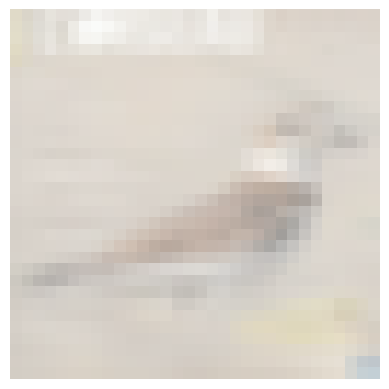

In [ ]:
testiter = iter(testloader)
images, labels = next(testiter)

i = 70
#i = random.randint(0, len(images))
print(i)
img = images[i]
plt.imshow(to_plt(img))
plt.axis('off')
print("True label: ", class_names[labels[i]])

And embed it (after CLIP's pre-processing) into **the same 512-dimensional vector space** as the label prompts

In [ ]:
image = processor(
    text=None,
    images=img,
    return_tensors='pt',
    do_rescale=False,
)['pixel_values'].to(device)

img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

Let's detach the two embeddings, move them to cpu, and convert into numpy arrays (you can skip this last part if you want to continue using pytorch)

In [ ]:
label_emb = label_emb.detach().cpu().numpy()
img_emb = img_emb.detach().cpu().numpy()

**TODO:** compute cosine similarity scores between the image embedding and each of the label embeddings. The label with the largest similarity: that is your class prediction

In [ ]:
# scores = ...

# SOLUTION
# Normalize both vectors
label_emb = label_emb / np.linalg.norm(label_emb, axis=1, keepdims=True)

img_emb = img_emb / np.linalg.norm(img_emb, axis=1, keepdims=True)

# Compute dot product
scores = np.dot(img_emb, label_emb.T)
# END SOLUTION

print(scores)
print(class_names[np.argmax(scores)])

[[0.23068209 0.2108412  0.275805   0.22941285 0.21767744 0.23593232
  0.22266763 0.22054869 0.21305087 0.20851128]]
bird


### Visualization

It is not easy to visualize 512-dimensional vectors...however we can display the (scalar) **angles** between the image embedding and each label embedding on the unit circle:

[76.662766 77.82834  73.99     76.737495 77.42734  76.35341  77.13423
 77.25873  77.69879  77.96487 ]


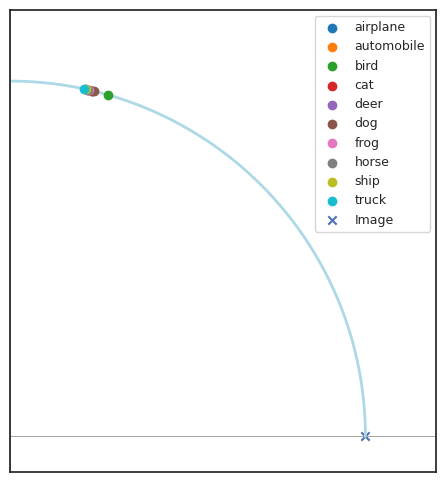

In [ ]:
angles = np.arccos(scores)[0]
print(np.rad2deg(angles))

colors = plt.cm.tab10(np.linspace(0, 1, len(angles)))  # Use a colormap for distinct colors

# Compute x, y coordinates on the unit circle
x = np.cos(angles)
y = np.sin(angles)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 1.2)
ax.set_ylim(-0.1, 1.2)
ax.set_aspect('equal')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)

# Draw the unit circle (only first quadrant)
theta = np.linspace(0, np.pi / 2, 100)
ax.plot(np.cos(theta), np.sin(theta), color='lightblue', linewidth=2)

# Plot points on the circle with different colors
for i, (xi, yi, color) in enumerate(zip(x, y, colors)):
    ax.scatter(xi, yi, color=color, zorder=3, label=class_names[i])
ax.scatter(1, 0, marker='x', label='Image')


# Add legend
ax.legend(loc="upper right", fontsize=9, title_fontsize=10)

# Labels
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Another thing we can do is using **TSNE** to obtain a visualization of the high-dimensional embeddings in 2D or 3D space. We will use *cosine distance* (wich is just one minus cosine similarity) as metric to reflect our classification criterion.

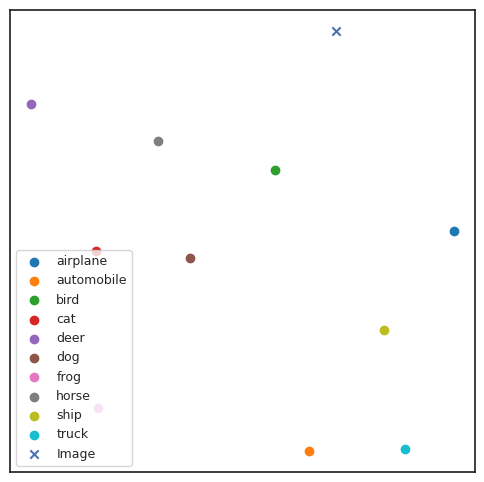

In [ ]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_distances

fig, ax = plt.subplots(figsize=(6, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(angles)))  # Use a colormap for distinct colors

# Stack into a single NumPy array
data = np.vstack((label_emb, img_emb))

cosine_dist = cosine_distances(data)
tsne = TSNE(n_components=2, metric="precomputed", init="random", perplexity=6, random_state=seed)
embedded = tsne.fit_transform(cosine_dist)

x = embedded[:-1, 0]
y = embedded[:-1, 1]

for i, (xi, yi, color) in enumerate(zip(x, y, colors)):
    ax.scatter(xi, yi, color=color, zorder=3, label=class_names[i])
ax.scatter(embedded[-1, 0], embedded[-1, 1], marker='x', label='Image')

ax.legend(loc="lower left", fontsize=9, title_fontsize=10)

ax.set_xticks([])
ax.set_yticks([])
plt.show()

**TODO:** let's turn these code snippets into a zero-shot image classifier:

In [ ]:
def text_encoding(labels):
  clip_labels = [f"a photo of a {label}" for label in class_names]
  label_tokens = processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
  ).to(device)
  label_emb = model.get_text_features(**label_tokens)
  label_emb = label_emb.detach().cpu().numpy()
  return label_emb

def image_encoding(images):
    images = processor(
    text=None,
    images=images,
    return_tensors='pt',
    do_rescale=False,
    )['pixel_values'].to(device)
    img_emb = model.get_image_features(images)
    img_emb = img_emb.detach().cpu().numpy()
    return img_emb

def zero_shot_classify(images, candidate_labels):
  """
    Inputs:
      images - A batch of images of shape (Batchsize, Channels, Width, Height)
      candidate_labels - A list of class names (strings)
    Returns: class predictions as indexes between 0 and len(candidate_labels),
             one for each image,
             as an array of shape (Batchsize,)
  """
  #return ...
  #SOLUTION

  # Text encoding
  label_emb = text_encoding(class_names)

  # Image encoding
  img_emb = image_encoding(images)

  # Compute cosine similarity scores
  label_emb = label_emb / np.linalg.norm(label_emb, axis=1, keepdims=True)
  img_emb = img_emb / np.linalg.norm(img_emb, axis=1, keepdims=True)
  scores = np.dot(img_emb, label_emb.T)

  # Compute predictions
  return np.argmax(scores, axis=1)
  #END SOLUTION

Let's try it on our dataset:

In [ ]:
testiter = iter(testloader)
images, labels = next(testiter)
predicted = zero_shot_classify(images, class_names)

Let's see the result on some random images first:

True label:  truck
Predicted:  truck


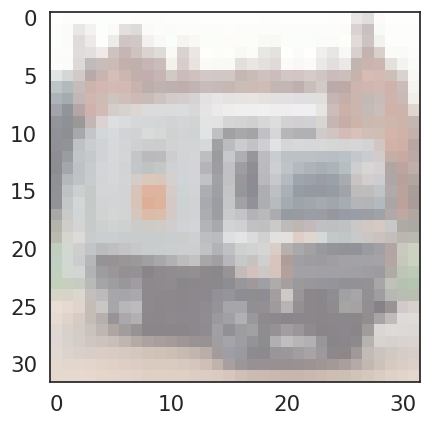

In [ ]:
i = 11
#i = random.randint(0, len(images))
img = images[i]

plt.imshow(to_plt(img))
print("True label: ", class_names[labels[i]])
print("Predicted: ", class_names[predicted[i]])

Finally, let's measure the accuracy:

In [ ]:
correct = 0
total = len(images)

with torch.no_grad():
    for img, lab, pred in zip(images, labels, predicted):
        correct += int(pred == lab)
accuracy = 100 * correct / total
print(f'Test accuracy: {accuracy:.2f}%')

Test accuracy: 91.41%
